In [ ]:
import os, math, random, time
import numpy as np
import pandas as pd

F_SPECIES = "species_targets.csv"   
F_W       = "W_matrix.csv"          
F_NODES   = "nodes_144.csv"       
F_ADJ     = "adjacency.csv"       
F_OUT     = "assignments_ga.csv"   

RADIUS_M  = 3.2  

RAND_SEED = 42
rng = np.random.default_rng(RAND_SEED) 
random.seed(RAND_SEED)


SPECIES_IDS = [
    "AG_LEC","AG_SAL","AG_SCB","AG_STR",
    "OP_CAN","OP_ENG","OP_ROB","OP_STR",
    "PR_LAE","YU_FIL"
]
SIDX = {s:i for i,s in enumerate(SPECIES_IDS)}

WRITE_ADJ = True
FORCE_REBUILD_ADJ = False


In [ ]:
species_df = pd.read_csv(F_SPECIES).copy()
nodes_df   = pd.read_csv(F_NODES).copy()
W_df       = pd.read_csv(F_W).copy()


nodes_df["status"]     = nodes_df["status"].astype(str).str.lower().str.strip()
nodes_df["species_id"] = nodes_df["species_id"].fillna("").astype(str).str.strip()
nodes_df["x"] = pd.to_numeric(nodes_df["x"], errors="coerce")
nodes_df["y"] = pd.to_numeric(nodes_df["y"], errors="coerce")

required_species_cols = {"species_id","f_target","v_tol"}
if not required_species_cols.issubset(set(species_df.columns)):
    raise ValueError(f"[species_targets.csv] faltan columnas: {sorted(required_species_cols)}")

species_df["species_id"] = species_df["species_id"].astype(str).str.strip()
missing = set(SPECIES_IDS) - set(species_df["species_id"])
extra   = set(species_df["species_id"]) - set(SPECIES_IDS)
if missing or extra:
    raise ValueError(f"[species_targets.csv] desalineado.\nFaltan: {sorted(missing)}\nSobran: {sorted(extra)}")

species_df = (species_df
              .set_index("species_id")
              .loc[SPECIES_IDS]
              .reset_index())

species_df["f_target"] = pd.to_numeric(species_df["f_target"], errors="raise")
species_df["v_tol"]    = pd.to_numeric(species_df["v_tol"],    errors="raise")
sum_f = float(species_df["f_target"].sum())
if sum_f <= 0:
    raise ValueError("f_target debe sumar > 0.")
species_df["f_target"] = species_df["f_target"] / sum_f

species_ids = SPECIES_IDS[:]      
E = len(species_ids)
e2idx = {e: i for i, e in enumerate(species_ids)}

W_df.columns = [c.strip() for c in W_df.columns]
if W_df.columns[0].lower() != "species_id":
    raise ValueError("[W_matrix.csv] la primera columna debe llamarse 'species_id'.")

W_df["species_id"] = W_df["species_id"].astype(str).str.strip()
W_df = W_df.set_index("species_id")

miss_rows = set(species_ids) - set(W_df.index)
miss_cols = set(species_ids) - set(W_df.columns)
if miss_rows or miss_cols:
    raise ValueError(f"[W_matrix.csv] faltan ids en filas/cols. filas={miss_rows}, cols={miss_cols}")

W_df = W_df.loc[species_ids, species_ids].astype(float)
W_sym = 0.5 * (W_df + W_df.T)
W_sym[W_sym < 0.0] = 0.0
W_np = W_sym.to_numpy()

f_vec = species_df["f_target"].to_numpy(float)  
v_vec = species_df["v_tol"].to_numpy(float)     


In [ ]:

exist_df = nodes_df[nodes_df["status"] == "existing"].copy()
avail_df = nodes_df[nodes_df["status"] == "available"].copy()


exist_df["node_id"] = exist_df["node_id"].astype(str)
avail_df["node_id"] = avail_df["node_id"].astype(str)


avail_df = avail_df.reset_index(drop=True)
exist_df = exist_df.reset_index(drop=True)
N = len(avail_df)


aidx = {nid: i for i, nid in enumerate(avail_df["node_id"])}
eidx = {nid: i for i, nid in enumerate(exist_df["node_id"])}


def build_edges_radius(df_all: pd.DataFrame, radius: float):
    """Vecindad por umbral de distancia (sin doble conteo). Devuelve pares (u,v) con u<v (str)."""
    pts = df_all[["x", "y"]].to_numpy(float)
    ids = df_all["node_id"].astype(str).tolist()

    cell = {}
    s = radius
    for k, (x, y) in enumerate(pts):
        cx, cy = int(math.floor(x / s)), int(math.floor(y / s))
        cell.setdefault((cx, cy), []).append(k)

    edges = set()
    neigh = [(dx, dy) for dx in (-1, 0, 1) for dy in (-1, 0, 1)]
    r2 = radius * radius

    for (cx, cy), idxs in cell.items():
        cand = set()
        for dx, dy in neigh:
            cand.update(cell.get((cx + dx, cy + dy), []))
        for i in idxs:
            xi, yi = pts[i]
            for j in cand:
                if j <= i:
                    continue  
                dx = xi - pts[j, 0]
                dy = yi - pts[j, 1]
                if dx * dx + dy * dy <= r2:
                    u, v = ids[i], ids[j]
                    if v < u:  
                        u, v = v, u
                    edges.add((u, v))
    return sorted(edges)

active_df = pd.concat([exist_df, avail_df], ignore_index=True)
active_df["node_id"] = active_df["node_id"].astype(str)
active_ids = set(active_df["node_id"])


if os.path.exists(F_ADJ) and not FORCE_REBUILD_ADJ:
    adj_df = pd.read_csv(F_ADJ)
    adj_df = adj_df.rename(columns={adj_df.columns[0]: "u_node_id", adj_df.columns[1]: "v_node_id"})
    adj_df["u_node_id"] = adj_df["u_node_id"].astype(str)
    adj_df["v_node_id"] = adj_df["v_node_id"].astype(str)
    adj_df = adj_df[
        adj_df["u_node_id"].isin(active_ids) & adj_df["v_node_id"].isin(active_ids)
    ].copy()
    uv = np.where(adj_df["u_node_id"] <= adj_df["v_node_id"],
                  adj_df["u_node_id"], adj_df["v_node_id"])
    vv = np.where(adj_df["u_node_id"] <= adj_df["v_node_id"],
                  adj_df["v_node_id"], adj_df["u_node_id"])
    adj_df = pd.DataFrame({"u_node_id": uv, "v_node_id": vv}).drop_duplicates()
else:
    edges = build_edges_radius(active_df, RADIUS_M)
    adj_df = pd.DataFrame(edges, columns=["u_node_id", "v_node_id"])
    if WRITE_ADJ:
        adj_df.to_csv(F_ADJ, index=False)


set_avail = set(avail_df["node_id"])
set_exist = set(exist_df["node_id"])

edges_nn = []
edges_ne = [] 

for u, v in adj_df[["u_node_id", "v_node_id"]].itertuples(index=False, name=None):
    inA_u, inA_v = (u in set_avail), (v in set_avail)
    inE_u, inE_v = (u in set_exist), (v in set_exist)
    if inA_u and inA_v:
        edges_nn.append((u, v))          
    elif inA_u and inE_v:
        edges_ne.append((u, v))         
    elif inE_u and inA_v:
        edges_ne.append((v, u))         


edges_nn = sorted(set(edges_nn))
edges_ne = sorted(set(edges_ne))

if edges_nn:
    nn_u = np.array([aidx[u] for (u, _) in edges_nn], dtype=np.int32)
    nn_v = np.array([aidx[v] for (_, v) in edges_nn], dtype=np.int32)
else:
    nn_u = np.zeros(0, dtype=np.int32)
    nn_v = np.zeros(0, dtype=np.int32)


exist_species_idx = np.array([e2idx.get(sp, -1) for sp in exist_df["species_id"]], dtype=np.int32)

if edges_ne:
    ne_i  = np.array([aidx[u] for (u, _) in edges_ne], dtype=np.int32)
    ne_jE = np.array([exist_species_idx[eidx[v]] for (_, v) in edges_ne], dtype=np.int32)
else:
    ne_i  = np.zeros(0, dtype=np.int32)
    ne_jE = np.zeros(0, dtype=np.int32)


In [ ]:
T = len(avail_df) + len(exist_df) 
P_e = {e: int((exist_df["species_id"] == e).sum()) for e in species_ids}


f = {row.species_id: float(row.f_target) for row in species_df.itertuples(index=False)}
v = {row.species_id: float(row.v_tol)    for row in species_df.itertuples(index=False)}

lower, upper = {}, {}
for e in species_ids:
    lo = math.ceil((f[e] - v[e]) * T - P_e[e])
    up = math.floor((f[e] + v[e]) * T - P_e[e])
    lower[e] = max(0, lo)
    upper[e] = max(0, up)

N_new = len(avail_df)

bad = [(e, lower[e], upper[e]) for e in species_ids if lower[e] > upper[e]]
if bad:
    raise ValueError(f"Infeasible bands per species (L>U): {bad}")

sumL = sum(lower.values()); sumU = sum(upper.values())
if sumL > N_new or N_new > sumU:
    raise ValueError(f"Infeasible totals: sum L={sumL}, N_new={N_new}, sum U={sumU}")


x_target = {e: int(round(f[e] * T - P_e[e])) for e in species_ids}

def project_counts(x):
    x2 = {e: max(lower[e], min(upper[e], x[e])) for e in species_ids}

    for _ in range(2):
        s = sum(x2.values())
        if s < N_new:
            deficit = N_new - s
            order = sorted(species_ids, key=lambda e: (upper[e] - x2[e]), reverse=True)
            for e in order:
                if deficit <= 0: break
                add = min(deficit, upper[e] - x2[e])
                if add > 0:
                    x2[e] += add
                    deficit -= add
        elif s > N_new:
            excess = s - N_new
            order = sorted(species_ids, key=lambda e: (x2[e] - lower[e]), reverse=True)
            for e in order:
                if excess <= 0: break
                dec = min(excess, x2[e] - lower[e])
                if dec > 0:
                    x2[e] -= dec
                    excess -= dec
        else:
            break
    return x2

x_feasible = project_counts(x_target)

if sum(x_feasible.values()) != N_new:
    raise ValueError("No fue posible proyectar a una composición factible con las bandas dadas (sin pisos).")

species_tokens = np.concatenate([
    np.repeat(e2idx[e], x_feasible[e]) for e in species_ids
]).astype(np.int16)


In [ ]:

W = W_np  
has_nn = len(nn_u) > 0
has_ne = len(ne_i) > 0

def evaluate_cost(assign_idx):
    """
    assign_idx: np.array shape (N_new,), entero en [0,E-1], especie en cada nodo available[i]
    Costo = sum W[e_i, e_j] en NN + sum W[e_i, e_exist] en NE
    """
    cost = 0.0
    if has_nn:
        cost += float(np.sum(W[assign_idx[nn_u], assign_idx[nn_v]]))
    if has_ne:
        cost += float(np.sum(W[assign_idx[ne_i], ne_jE]))
    return cost

adj_nn_out = [[] for _ in range(N)]
for u, v in zip(nn_u, nn_v):
    adj_nn_out[u].append(v)
    adj_nn_out[v].append(u)

adj_ne_out = [[] for _ in range(N)]  
for i, eidx_exist in zip(ne_i, ne_jE):
    adj_ne_out[i].append(eidx_exist)

def delta_swap(assign_idx, p, q):
    """
    Delta de costo al intercambiar las especies de los nodos available p y q.
    Importante: la arista (p, q) NO aporta delta si W es simétrica, así que se omite.
    """
    if p == q:
        return 0.0
    e_p_old = assign_idx[p]
    e_q_old = assign_idx[q]
    if e_p_old == e_q_old:
        return 0.0

    d = 0.0

    for t in adj_nn_out[p]:
        if t == q:
            continue
        d += W[e_q_old, assign_idx[t]] - W[e_p_old, assign_idx[t]]

    for t in adj_nn_out[q]:
        if t == p:
            continue
        d += W[e_p_old, assign_idx[t]] - W[e_q_old, assign_idx[t]]

    if has_ne:
        for e_exist in adj_ne_out[p]:
            d += W[e_q_old, e_exist] - W[e_p_old, e_exist]
        for e_exist in adj_ne_out[q]:
            d += W[e_p_old, e_exist] - W[e_q_old, e_exist]

    return float(d)


In [ ]:
def greedy_initial():
    """
    Asigna especies respetando x_feasible, minimizando costo incremental local.
    """
    remaining = x_feasible.copy()                
    assign = -np.ones(N, dtype=np.int16)


    deg = np.array([len(adj_nn_out[i]) + len(adj_ne_out[i]) for i in range(N)])
    order = np.argsort(-deg)

    for i in order:
        best_e_str = None
        best_inc = 1e18

        for e_str, cnt in remaining.items():
            if cnt <= 0:
                continue
            e = e2idx[e_str]

            inc = 0.0
            
            for t in adj_nn_out[i]:
                if assign[t] != -1:
                    inc += W[e, assign[t]]
            
            for e_exist in adj_ne_out[i]:
                inc += W[e, e_exist]

            if inc < best_inc:
                best_inc = inc
                best_e_str = e_str

        
        if best_e_str is None:
            best_e_str = max(remaining, key=lambda k: remaining[k])
        assign[i] = np.int16(e2idx[best_e_str])
        remaining[best_e_str] -= 1

    return assign


def random_initial():
    return rng.permutation(species_tokens)


def crossover_preserve(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Crossover uniforme con reparación EXACTA a la multiset objetivo x_feasible.
    a, b: arrays de especies (índices) de longitud N.
    Retorna hijo con cuentas == x_feasible.
    """
    n = len(a)
   
    mask = rng.random(n) < 0.5
    child = np.where(mask, a, b).astype(np.int16, copy=True)

    
    desired = np.array([x_feasible[e] for e in species_ids], dtype=int)

    
    cur_counts = np.bincount(child, minlength=len(species_ids)).astype(int)

 
    surplus_idx = np.where(cur_counts > desired)[0].tolist()
    deficit_idx = np.where(cur_counts < desired)[0].tolist()

    if not surplus_idx and not deficit_idx:
        return child 

    surplus_pos = {e: [] for e in surplus_idx}
    for pos, e in enumerate(child):
        if e in surplus_pos:
            surplus_pos[e].append(pos)

    
    for e_def in deficit_idx:
        need = desired[e_def] - cur_counts[e_def]
        if need <= 0:
            continue
        while need > 0 and surplus_idx:
            e_sup = max(surplus_idx, key=lambda k: cur_counts[k] - desired[k])
            have = cur_counts[e_sup] - desired[e_sup]
            if have <= 0 or not surplus_pos[e_sup]:
                surplus_idx.remove(e_sup)
                continue
            
            pos = surplus_pos[e_sup].pop()
            child[pos] = np.int16(e_def)
            cur_counts[e_sup] -= 1
            cur_counts[e_def] += 1
            need -= 1
            if cur_counts[e_sup] <= desired[e_sup]:
                if e_sup in surplus_idx:
                    surplus_idx.remove(e_sup)

    final_counts = np.bincount(child, minlength=len(species_ids))
    target_counts = np.array([x_feasible[e] for e in species_ids], dtype=int)
    if not np.array_equal(final_counts, target_counts):
        raise RuntimeError("crossover_preserve no logró ajustar exactamente a x_feasible.")

    return child


def mutate_swap(assign: np.ndarray, p_swap: float = 0.2) -> np.ndarray:
    """Swap entre dos posiciones (preserva cuentas). Usa RNG reproducible."""
    child = assign.copy()
    if rng.random() < p_swap:
        if N >= 2:
            i, j = rng.integers(0, N, size=2)
            if i != j:
                child[i], child[j] = child[j], child[i]
    return child


def local_search(assign: np.ndarray, max_iters: int = 200):
    """
    Búsqueda local 1-intercambio con delta costo; respeta multiset (solo swaps).
    """
    cur = assign.copy()
    cur_cost = evaluate_cost(cur)
    for _ in range(max_iters):
        i = rng.integers(0, N)
        cand = adj_nn_out[i]
        j = random.choice(cand) if cand else rng.integers(0, N)
        if i == j:
            continue
        d = delta_swap(cur, i, j)
        if d < -1e-8:
            cur[i], cur[j] = cur[j], cur[i]
            cur_cost += d
    return cur, cur_cost


In [ ]:
POP = 40            
ELITE = 4           
GENS = 200        
LS_RATE = 0.3      
TOUR = 3           

pop = []
g0 = greedy_initial()
pop.append(g0)
while len(pop) < POP:
    pop.append(random_initial())

pop = [p.copy() for p in pop]
fitness = np.array([evaluate_cost(p) for p in pop], dtype=float)
best_idx = int(np.argmin(fitness))
best, best_cost = pop[best_idx].copy(), float(fitness[best_idx])

def tournament_select():
    idx = rng.choice(len(pop), size=TOUR, replace=False)
    j = idx[np.argmin(fitness[idx])]
    return pop[j]

history = []
t0 = time.time()
for g in range(GENS):
    
    order = np.argsort(fitness)
    pop = [pop[i] for i in order]
    fitness = fitness[order]

    new_pop = pop[:ELITE]
    new_fit = fitness[:ELITE].tolist()

    while len(new_pop) < POP:
        p1 = tournament_select()
        p2 = tournament_select()
        c  = crossover_preserve(p1, p2)
        c  = mutate_swap(c, p_swap=0.3)

        if rng.random() < LS_RATE:
            c, c_cost = local_search(c, max_iters=100)
        else:
            c_cost = evaluate_cost(c)

        new_pop.append(c)
        new_fit.append(c_cost)

    pop = new_pop
    fitness = np.array(new_fit, dtype=float)

    k = int(np.argmin(fitness))
    if fitness[k] < best_cost - 1e-8:
        best, best_cost = pop[k].copy(), float(fitness[k])

    history.append(best_cost)
    if (g+1) % 20 == 0:
        print(f"Gen {g+1:4d} | best={best_cost:,.2f}")

t1 = time.time()
print(f"Tiempo total: {t1-t0:.1f}s  | Costo final: {best_cost:,.2f}")


Gen   20 | best=168.80
Gen   40 | best=167.65
Gen   60 | best=167.33
Gen   80 | best=167.29
Gen  100 | best=167.20
Gen  120 | best=167.15
Gen  140 | best=167.08
Gen  160 | best=166.82
Gen  180 | best=166.79
Gen  200 | best=166.76
Tiempo total: 1.4s  | Costo final: 166.76


In [ ]:

assign_species = [species_ids[k] for k in best]  
if len(assign_species) != len(avail_df):
    raise ValueError("assign_species y avail_df tienen longitudes distintas.")

out = avail_df[["node_id", "x", "y"]].copy()
out["node_id"]   = out["node_id"].astype(str)
out["status"]    = "available_assigned"
out["species_id"] = assign_species


exist_out = exist_df[["node_id", "x", "y", "status", "species_id"]].copy()
exist_out["node_id"] = exist_out["node_id"].astype(str)


final_out = pd.concat([exist_out, out], ignore_index=True)
final_out.to_csv(F_OUT, index=False)
print(f"Escribí: {F_OUT}")

f_map = dict(zip(species_df["species_id"], species_df["f_target"].astype(float)))
v_map = dict(zip(species_df["species_id"], species_df["v_tol"].astype(float)))


counts_new = (
    pd.Series(assign_species, dtype=str)
      .value_counts()
      .reindex(species_ids, fill_value=0)
      .astype(int)
)


total_final = {e: int(counts_new[e]) + int(P_e.get(e, 0)) for e in species_ids}

lower_total = [int(math.ceil(max(0.0, (f_map[e] - v_map[e]) * T))) for e in species_ids]
upper_total = [int(math.floor((f_map[e] + v_map[e]) * T))         for e in species_ids]

summary = pd.DataFrame({
    "species_id":  species_ids,
    "P_exist":     [int(P_e.get(e, 0))     for e in species_ids],
    "x_new":       [int(counts_new[e])     for e in species_ids],
    "total_final": [int(total_final[e])    for e in species_ids],
    "lower":       lower_total,
    "upper":       upper_total,
})
summary["feasible_band"] = (
    (summary["total_final"] >= summary["lower"]) &
    (summary["total_final"] <= summary["upper"])
)
print(summary)


from collections import OrderedDict

row = OrderedDict()
row["fitness"] = float(best_cost)  
for e in species_ids:
    row[f"new_{e}"]   = int(counts_new[e])
for e in species_ids:
    row[f"final_{e}"] = int(total_final[e])
for e in species_ids:
    row[f"exist_{e}"] = int(P_e.get(e, 0))

pd.DataFrame([row]).to_csv("ga_results_row.csv", index=False)
print("Escribí: ga_results_row.csv  (mismo formato que solver_results_row.csv)")


Escribí: assignments_ga.csv
  species_id  P_exist  x_new  total_final  lower  upper  feasible_band
0     AG_LEC        0      9            9      8     10           True
1     AG_SAL        3     40           43     41     45           True
2     AG_SCB        0      9            9      8     10           True
3     AG_STR        4      5            9      8     10           True
4     OP_CAN        2      9           11     10     12           True
5     OP_ENG        2      6            8      7      9           True
6     OP_ROB        4     12           16     15     17           True
7     OP_STR        0     14           14     12     16           True
8     PR_LAE        0     19           19     17     21           True
9     YU_FIL        1      5            6      5      6           True
Escribí: ga_results_row.csv  (mismo formato que solver_results_row.csv)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

    plt.figure(figsize=(6, 3))
    plt.plot(history)
    plt.xlabel("Generaciones")
    plt.ylabel("Mejor costo")
    plt.title("Convergencia GA")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("ga_convergence.png", dpi=200)
    plt.show()
    print("Guardado: ga_convergence.png")
else:
    print("[Aviso] 'history' vacío: no hay nada que graficar.")


def cost_breakdown(assign_idx: np.ndarray):
    
    a = assign_idx.astype(np.int32, copy=False)
    c_nn = float(np.sum(W[a[nn_u], a[nn_v]])) if has_nn else 0.0
    c_ne = float(np.sum(W[a[ne_i],  ne_jE]))   if has_ne else 0.0
    return c_nn, c_ne, c_nn + c_ne

c_nn, c_ne, c_tot = cost_breakdown(best)
print(f"Costo NN={c_nn:,.2f}  NE={c_ne:,.2f}  TOTAL={c_tot:,.2f}")


c_eval = float(evaluate_cost(best))
if abs(c_eval - c_tot) > 1e-8:
    print(f"[ADVERTENCIA] evaluate_cost(best)={c_eval:,.6f} difiere de breakdown TOTAL={c_tot:,.6f}")

pd.DataFrame([{
    "ga_cost_nn": c_nn,
    "ga_cost_ne": c_ne,
    "ga_cost_total": c_tot,
    "ga_best_cost": float(best_cost),
    "diff_eval_minus_total": float(c_eval - c_tot)
}]).to_csv("ga_cost_breakdown.csv", index=False)
print("Guardado: ga_cost_breakdown.csv")


IndentationError: unexpected indent (4067005788.py, line 7)

# GRÁFICAS

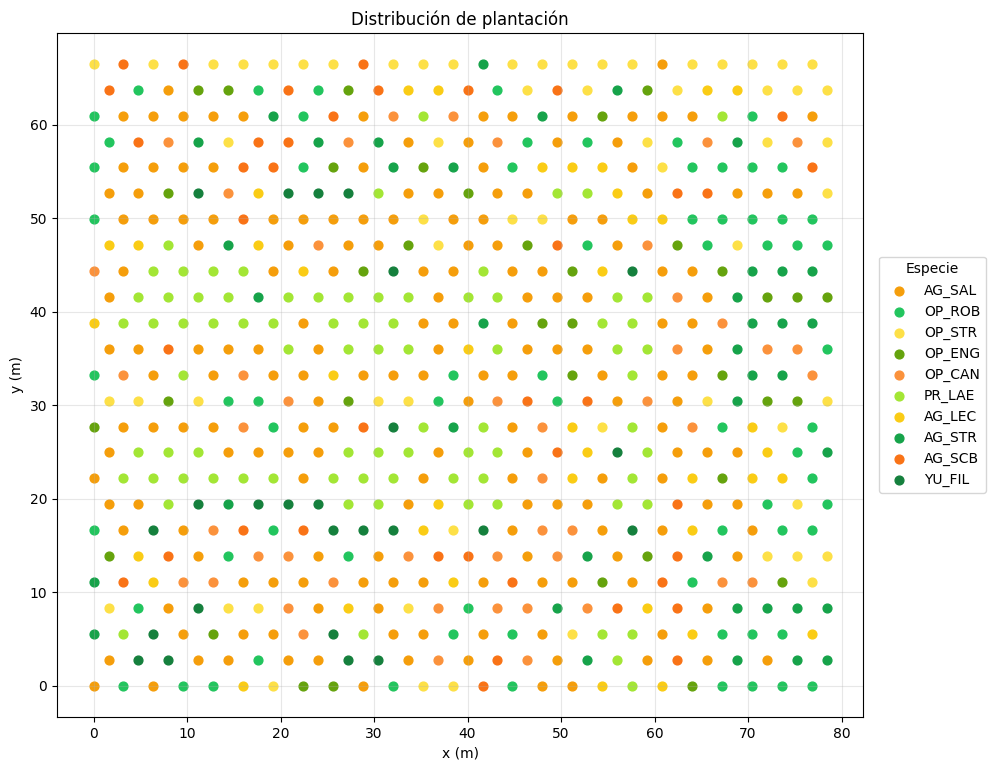

Mapa guardado en: plantacion_mapa.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Palette por especie
PALETTE = {
    "AG_SAL": "#F59E0B",  # Agave salmiana
    "OP_ROB": "#22C55E",  # Opuntia robusta
    "OP_STR": "#FDE047",  # Opuntia streptacantha
    "OP_ENG": "#65A30D",  # Opuntia engelmannii
    "OP_CAN": "#FB923C",  # Opuntia cantabrigiensis
    "PR_LAE": "#A3E635",  # Prosopis laevigata
    "AG_LEC": "#FACC15",  # Agave lechuguilla
    "AG_STR": "#16A34A",  # Agave striata
    "AG_SCB": "#F97316",  # Agave scabra
    "YU_FIL": "#15803D",  # Yucca filifera
}
DEFAULT_COLOR = "#999999"

df = pd.read_csv("assignments_ga.csv")


df["status"] = df["status"].str.lower().str.strip()
plot_df = df[(df["status"] != "blocked") & df["species_id"].notna()].copy()


present_species = set(plot_df["species_id"].unique())
species_order = [s for s in PALETTE.keys() if s in present_species]
species_order += [s for s in sorted(present_species) if s not in PALETTE]


xrange = plot_df["x"].max() - plot_df["x"].min()
yrange = plot_df["y"].max() - plot_df["y"].min()
if xrange == 0:
    xrange = 1.0
aspect = yrange / xrange
fig_w = 10
fig_h = max(6, fig_w * aspect)

plt.figure(figsize=(fig_w, fig_h))


for sp in species_order:
    sub = plot_df[plot_df["species_id"] == sp]
    color = PALETTE.get(sp, DEFAULT_COLOR)
    plt.scatter(sub["x"], sub["y"], s=40, label=sp, color=color)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Distribución de plantación")
plt.grid(True, alpha=0.3)
plt.legend(title="Especie", loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)


out_png = "plantacion_mapa.png"
plt.tight_layout()
plt.savefig(out_png, dpi=200)
plt.show()

print(f"Mapa guardado en: {out_png}")


species_id  count  percent
    AG_SAL    186    29.76
    PR_LAE     81    12.96
    OP_ROB     69    11.04
    OP_STR     61     9.76
    OP_CAN     47     7.52
    AG_LEC     40     6.40
    AG_SCB     40     6.40
    AG_STR     40     6.40
    OP_ENG     36     5.76
    YU_FIL     25     4.00


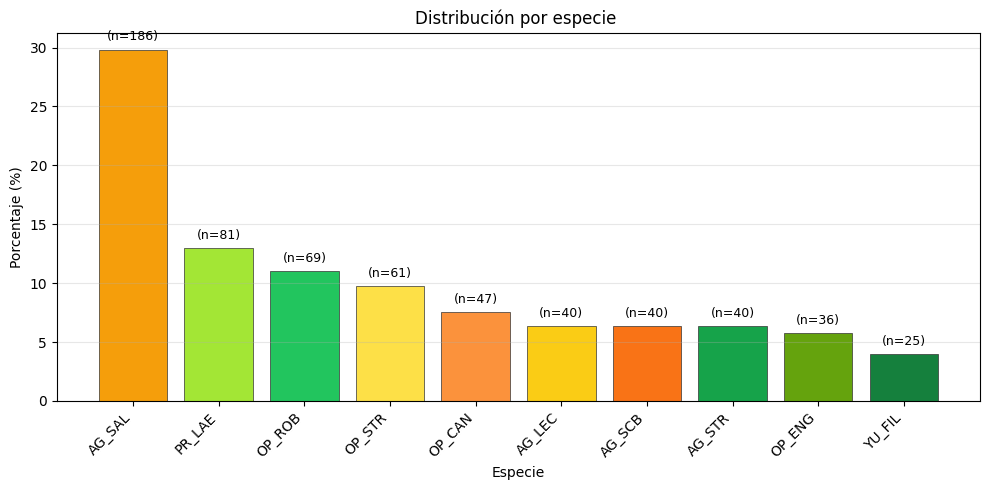

Guardados: composition_counts.csv y hist_porcentajes_especie.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

PALETTE = {
    "AG_SAL": "#F59E0B", "OP_ROB": "#22C55E", "OP_STR": "#FDE047",
    "OP_ENG": "#65A30D", "OP_CAN": "#FB923C", "PR_LAE": "#A3E635",
    "AG_LEC": "#FACC15", "AG_STR": "#16A34A", "AG_SCB": "#F97316",
    "YU_FIL": "#15803D",
}
DEFAULT_COLOR = "#999999"


df = pd.read_csv("assignments_ga.csv")
df["status"] = df["status"].str.lower().str.strip()
df["species_id"] = df["species_id"].astype(str).str.strip()
plot_df = df[(df["status"] != "blocked") & (df["species_id"] != "")].copy()


counts = (plot_df.groupby("species_id", as_index=False)
          .size()
          .rename(columns={"size":"count"}))
total = counts["count"].sum()
counts["percent"] = (counts["count"] / total) * 100
counts = counts.sort_values("percent", ascending=False).reset_index(drop=True)

counts.to_csv("composition_counts.csv", index=False)


print(counts.to_string(index=False, float_format=lambda x: f"{x:0.2f}"))


colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in counts["species_id"]]

plt.figure(figsize=(10, 5))
bars = plt.bar(counts["species_id"], counts["percent"], color=colors, edgecolor="#333333", linewidth=0.5)

plt.ylabel("Porcentaje (%)")
plt.xlabel("Especie")
plt.title("Distribución por especie ")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)


for bar, cnt in zip(bars, counts["count"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + max(0.5, 0.02*y),
             f"(n={cnt})",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("hist_porcentajes_especie.png", dpi=200)
plt.show()

print("Guardados: composition_counts.csv y hist_porcentajes_especie.png")


species_id  expected_count  final_count  diff_count  expected_percent  final_percent  diff_percent  lower_percent  upper_percent  in_band
    AG_LEC           39.89           40        0.11              6.38           6.40          0.02           5.29           7.48     True
    AG_SAL          186.17          186       -0.17             29.79          29.76         -0.03          28.28          31.30     True
    AG_SCB           39.89           40        0.11              6.38           6.40          0.02           5.33           7.44     True
    AG_STR           39.89           40        0.11              6.38           6.40          0.02           5.29           7.47     True
    OP_CAN           46.54           47        0.46              7.45           7.52          0.07           6.38           8.52     True
    OP_ENG           36.09           36       -0.09              5.78           5.76         -0.02           4.79           6.76     True
    OP_ROB           69.34        

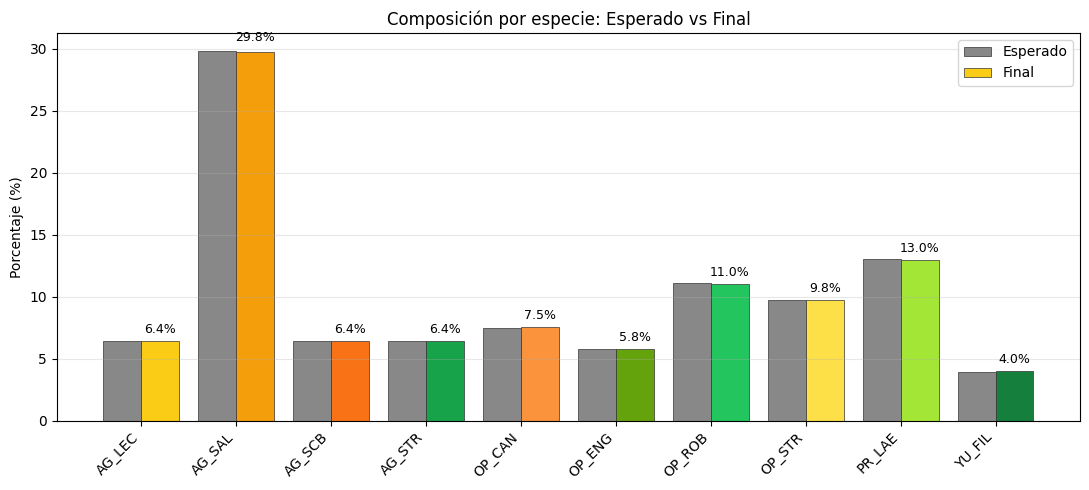

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


PALETTE = {
    "AG_SAL": "#F59E0B","OP_ROB": "#22C55E","OP_STR": "#FDE047","OP_ENG": "#65A30D",
    "OP_CAN": "#FB923C","PR_LAE": "#A3E635","AG_LEC": "#FACC15","AG_STR": "#16A34A",
    "AG_SCB": "#F97316","YU_FIL": "#15803D"
}
DEFAULT_COLOR = "#999999"


SPECIES_IDS = ["AG_LEC","AG_SAL","AG_SCB","AG_STR","OP_CAN","OP_ENG","OP_ROB","OP_STR","PR_LAE","YU_FIL"]


assign  = pd.read_csv("assignments_ga.csv")
targets = pd.read_csv("species_targets.csv") 


assign["status"] = assign["status"].str.lower().str.strip()
assign["species_id"] = assign["species_id"].astype(str).str.strip()
plot_df = assign[(assign["status"] != "blocked") & (assign["species_id"] != "")]
T = len(plot_df)


final_counts = (plot_df.groupby("species_id", as_index=False)
                .size().rename(columns={"size":"final_count"}))

df = (targets.copy()
      .assign(species_id=lambda d: d["species_id"].astype(str).str.strip())
      .set_index("species_id").reindex(SPECIES_IDS).reset_index())

df = df.merge(final_counts, on="species_id", how="left").fillna({"final_count":0})


df["expected_count"]   = df["f_target"] * T
df["expected_percent"] = df["f_target"] * 100
df["v_tol_percent"]    = df["v_tol"] * 100
df["lower_percent"]    = (df["f_target"] - df["v_tol"]) * 100
df["upper_percent"]    = (df["f_target"] + df["v_tol"]) * 100
df["final_percent"]    = (df["final_count"] / T) * 100
df["diff_count"]       = df["final_count"] - df["expected_count"]
df["diff_percent"]     = df["final_percent"] - df["expected_percent"]
df["in_band"]          = (df["final_percent"] >= df["lower_percent"]) & (df["final_percent"] <= df["upper_percent"])


cols_show = ["species_id","expected_count","final_count","diff_count",
             "expected_percent","final_percent","diff_percent","lower_percent","upper_percent","in_band"]
print(df[cols_show].round(2).to_string(index=False))
df.round(4).to_csv("composition_expected_vs_final.csv", index=False)
print("Guardado: composition_expected_vs_final.csv")

x = np.arange(len(df))
w = 0.4

fig, ax = plt.subplots(figsize=(11, 5))


ax.bar(x - w/2, df["expected_percent"], width=w, label="Esperado", color="#888888", edgecolor="#333333", linewidth=0.5)
colors = [PALETTE.get(sp, DEFAULT_COLOR) for sp in df["species_id"]]
bars = ax.bar(x + w/2, df["final_percent"], width=w, label="Final", color=colors, edgecolor="#333333", linewidth=0.5)

for bar, pct in zip(bars, df["final_percent"]):
    y = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, y + max(0.4, 0.02*y), f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x, df["species_id"], rotation=45, ha="right")
ax.set_ylabel("Porcentaje (%)")
ax.set_title("Composición por especie: Esperado vs Final")
ax.grid(axis="y", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig("comparacion_esperado_vs_final.png", dpi=200)
plt.show()
